In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('../../'))

import numpy as np
import theano.tensor as T
from theano import function, shared, config
from sklearn.metrics import mutual_info_score

from deepensemble.utils.utils_functions import ITLFunctions

## Function to compute the Mutual Information with Histogram

In [2]:
def calc_MI(X, Y, bins=25):
    c_XY = np.histogram2d(X, Y, bins)[0]
    c_X = np.histogram(X, bins)[0]
    c_Y = np.histogram(Y, bins)[0]

    H_X = shannon_entropy(c_X)
    H_Y = shannon_entropy(c_Y)
    H_XY = shannon_entropy(c_XY)

    MI = H_X + H_Y - H_XY
    return MI

## Function to compute the Quadratic Mutual Information (Euclidean) with Histogram

In [3]:
def calc_IED(X, Y, bins=25):
    c_XY = np.histogram2d(X, Y, bins)[0]
    c_X = np.histogram(X, bins)[0]
    c_Y = np.histogram(Y, bins)[0]

    p_XY = c_XY / float(np.sum(c_XY))
    p_Y = c_Y / float(np.sum(c_Y))
    p_X = c_X / float(np.sum(c_X))

    d1 = p_XY
    d2 = np.array([p_X * y for y in p_Y])
    d3 = p_XY * d2

    d1 = d1[np.nonzero(d1)]
    d2 = d2[np.nonzero(d2)]
    d3 = d3[np.nonzero(d3)]
    return np.sum(np.power(d1, 2)) + np.sum(np.power(d2, 2)) - 2. * np.sum(d3)

## Function to compute the Quadratic Mutual Information (Cauchy - Schwartz) with Histogram

In [4]:
def calc_ICS(X, Y, bins=25):
    c_XY = np.histogram2d(X, Y, bins)[0]
    c_X = np.histogram(X, bins)[0]
    c_Y = np.histogram(Y, bins)[0]

    p_XY = c_XY / float(np.sum(c_XY))
    p_Y = c_Y / float(np.sum(c_Y))
    p_X = c_X / float(np.sum(c_X))

    d1 = p_XY
    d2 = np.array([p_X * y for y in p_Y])
    d3 = p_XY * d2

    d1 = d1[np.nonzero(d1)]
    d2 = d2[np.nonzero(d2)]
    d3 = d3[np.nonzero(d3)]
    return np.log(np.sum(np.power(d1, 2))) + np.log(np.sum(np.power(d2, 2))) - 2. * np.log(np.sum(d3))

## Function to compute Shannon Entropy

In [5]:
def shannon_entropy(c):
    c_normalized = c / float(np.sum(c))
    # noinspection PyTypeChecker,PyUnresolvedReferences
    c_normalized = c_normalized[np.nonzero(c_normalized)]
    H = -sum(c_normalized * np.log(c_normalized))
    return H

## Plot differents way to compute Muntual Informations 

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt

N = 200
y1 = np.random.binomial(1, 0.5, (N, 1))
y1 = y1.astype(dtype=config.floatX)

_y2 = T.matrix('y2')
s = 1.06 * np.std(y1) * (len(y1)) ** (-0.2)  # Silverman

# noinspection PyTypeChecker
ITLFunctions.mutual_information_parzen(y1, y1, s=s)

# noinspection PyTypeChecker
_Ip = ITLFunctions.mutual_information_parzen(_y2, shared(y1), s=s)
fn_Ip = function([_y2], outputs=_Ip, allow_input_downcast=True)

_Ics = ITLFunctions.mutual_information_cs([_y2], shared(y1), s=np.sqrt(2) * s)
fn_Ics = function([_y2], outputs=_Ics, allow_input_downcast=True)

_Ied = ITLFunctions.mutual_information_ed([_y2], shared(y1), s=np.sqrt(2) * s)
fn_Ied = function([_y2], outputs=_Ied, allow_input_downcast=True)

Ics = []
Ics2 = []
Ied = []
Ied2 = []
I = []
Is = []
Ip = []
AUC = np.linspace(0, 1, 101)
for auc in AUC:
    y2 = y1.copy()
    m = int(auc * N)
    y2[:m] = 1 - y2[:m]

    Ip.append(fn_Ip(y2))
    Ics.append(fn_Ics(y2))
    Ied.append(fn_Ied(y2))
    # Ics2.append(calc_ICS(np.squeeze(y1), np.squeeze(y2)))
    # Ied2.append(calc_IED(np.squeeze(y1), np.squeeze(y2)))
    # Is.append(mutual_info_score(np.squeeze(y1), np.squeeze(y2)))
    # I.append(calc_MI(np.squeeze(y1), np.squeeze(y2)))

    

<IPython.core.display.Javascript object>


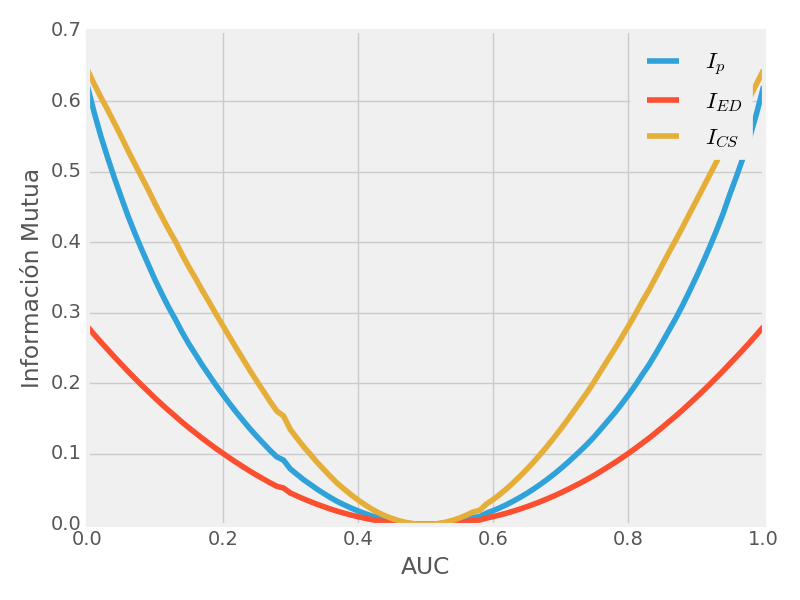

In [20]:
plt.style.use('fivethirtyeight')

f = plt.figure(dpi=100)

plt.plot(AUC, Ip,  label='$I_p$')
plt.plot(AUC, Ied, label='$I_{ED}$')
plt.plot(AUC, Ics, label='$I_{CS}$')
# plt.plot(AUC, I, label='$I$')
# plt.plot(AUC, Is, 'r', label='$I_S$')
# plt.plot(AUC, Is, 'r', label='$I_S$')
# plt.plot(AUC, Ied2, 'b', label='$I_{ED2}$')
plt.xlabel('AUC')
plt.ylabel('Información Mutua')
plt.legend()

plt.tight_layout()

plt.show()